Products Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ProductID    100 non-null    object 
 1   ProductName  100 non-null    object 
 2   Category     100 non-null    object 
 3   Price        100 non-null    float64
dtypes: float64(1), object(3)
memory usage: 3.2+ KB
None

Transactions Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   TransactionID    1000 non-null   object 
 1   CustomerID       1000 non-null   object 
 2   ProductID        1000 non-null   object 
 3   TransactionDate  1000 non-null   object 
 4   Quantity         1000 non-null   int64  
 5   TotalValue       1000 non-null   float64
 6   Price            1000 non-null   float64
dtypes: float64(2), int64(1), obje

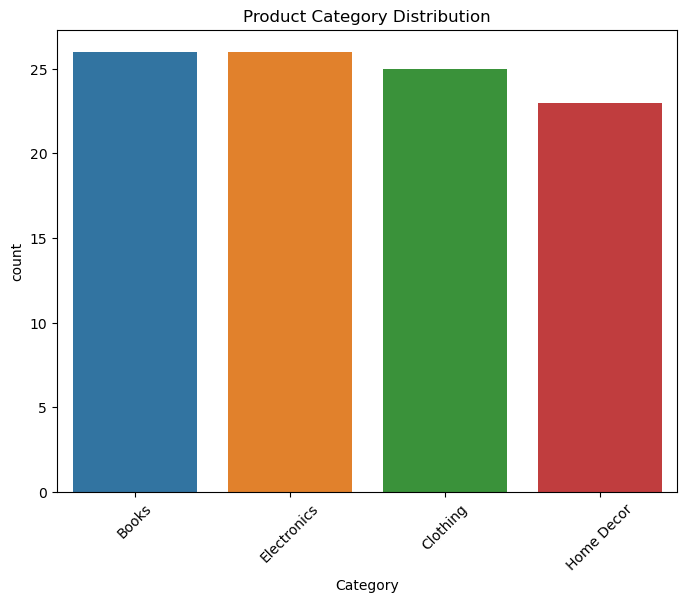

Davies-Bouldin Index: 1.3821342339586955


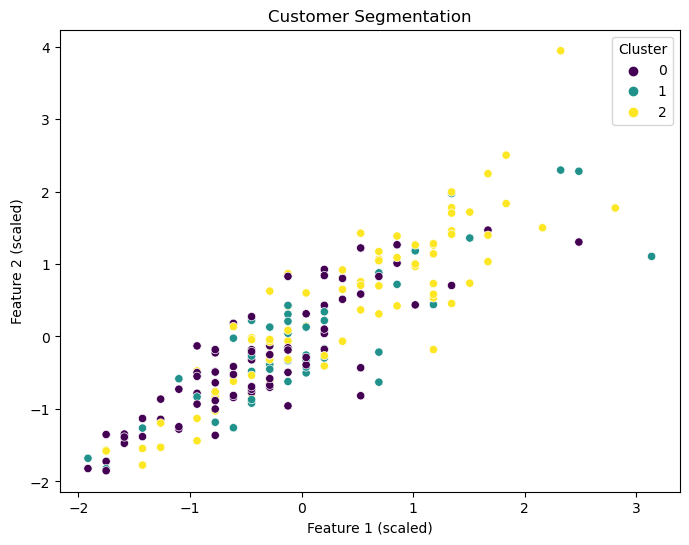

In [10]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score
import os
os.environ["OMP_NUM_THREADS"] = '1'
import warnings
warnings.filterwarnings('ignore')


# Load the datasets
products = pd.read_csv('Products.csv')
transactions = pd.read_csv('Transactions.csv')
customers = pd.read_csv('Customers.csv')

# --- Task 1: Exploratory Data Analysis ---
# Display basic info
print("Products Data:")
print(products.info())
print("\nTransactions Data:")
print(transactions.info())
print("\nCustomers Data:")
print(customers.info())

# Check for missing values
print("\nMissing values in Products:")
print(products.isnull().sum())
print("\nMissing values in Transactions:")
print(transactions.isnull().sum())
print("\nMissing values in Customers:")
print(customers.isnull().sum())

# Example visualization: Product category distribution
plt.figure(figsize=(8, 6))
sns.countplot(data=products, x='Category', order=products['Category'].value_counts().index)
plt.title('Product Category Distribution')
plt.xticks(rotation=45)
plt.show()

# --- Task 2: Lookalike Model ---
# Merge transaction data with product data
merged_data = pd.merge(transactions, products, on='ProductID')

# Create customer-product matrix
customer_product_matrix = merged_data.pivot_table(index='CustomerID', columns='ProductID', values='Quantity', fill_value=0)

# Compute cosine similarity between customers
similarity_matrix = cosine_similarity(customer_product_matrix)
similarity_df = pd.DataFrame(similarity_matrix, index=customer_product_matrix.index, columns=customer_product_matrix.index)

# Get top 3 similar customers for the first 20 customers
lookalike_results = {}
for customer_id in similarity_df.index[:20]:
    similar_customers = similarity_df.loc[customer_id].sort_values(ascending=False).iloc[1:4]
    lookalike_results[customer_id] = list(zip(similar_customers.index, similar_customers.values))

# Save the lookalike results as a CSV file
lookalike_df = pd.DataFrame({
    'CustomerID': lookalike_results.keys(),
    'Lookalikes': [str(v) for v in lookalike_results.values()]
})
lookalike_df.to_csv('Lookalike.csv', index=False)

# --- Task 3: Customer Segmentation ---
# Merge transaction data with customer data
customer_transactions = pd.merge(transactions, customers, on='CustomerID')

# Aggregate transaction data by customer
customer_data = customer_transactions.groupby('CustomerID').agg({
    'Quantity': 'sum',
    'TotalValue': 'sum',
    'Region': 'first',
    'SignupDate': 'first'
}).reset_index()

# Convert 'SignupDate' to datetime and extract year
customer_data['SignupDate'] = pd.to_datetime(customer_data['SignupDate'])
customer_data['SignupYear'] = customer_data['SignupDate'].dt.year

# Drop the original 'SignupDate' column
customer_data = customer_data.drop(columns=['SignupDate'])

# Encode categorical variables
customer_data = pd.get_dummies(customer_data, columns=['Region'], drop_first=True)

# Scale the features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(customer_data.drop(columns=['CustomerID']))

# Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
customer_data['Cluster'] = kmeans.fit_predict(scaled_data)

# Calculate Davies-Bouldin Index
db_index = davies_bouldin_score(scaled_data, customer_data['Cluster'])
print(f"Davies-Bouldin Index: {db_index}")

# Visualize the clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=scaled_data[:, 0], y=scaled_data[:, 1], hue=customer_data['Cluster'], palette='viridis')
plt.title('Customer Segmentation')
plt.xlabel('Feature 1 (scaled)')
plt.ylabel('Feature 2 (scaled)')
plt.show()

# Save customer segmentation results
customer_data.to_csv('Customer_Segmentation.csv', index=False)
